In [ ]:
# We want to test on CPU for fair comparison
%env JAX_PLATFORM_NAME=cpu

In [2]:
# %% Imports
import cv2 as cv
from flytracker.preprocessing import construct_undistort_map, preprocessing
from flytracker.annotating import annotate
from flytracker.tracker import run
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import jax
from functools import partial
from jax import numpy as jnp
from jax import lax
from jax import random

from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import seaborn as sns
sns.set()

In [3]:
# Paths
original_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/4arenas/seq_1.mp4"
mapping_folder = "/home/gert-jan/Documents/flyTracker/data/distortion_maps/"
df_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/4arenas/df.hdf"

In [4]:
# Loading dataframe - for initial values
df = pd.read_hdf(df_path, key="df")

In [5]:
def load(path, frame):
    capture = cv.VideoCapture(path)

    image_size = (
    int(capture.get(cv.CAP_PROP_FRAME_WIDTH)),
    int(capture.get(cv.CAP_PROP_FRAME_HEIGHT)),
)
    mask = np.ones(image_size, dtype=bool).T
    mask[:125, :] = 0
    mask[-170:, :] = 0
    mask[:, :220] = 0
    mask[:, -280:] = 0

    mapping = construct_undistort_map(image_size, mapping_folder)
    capture.set(1, frame)
    image = preprocessing(capture.read()[1], mapping=mapping, mask=mask)
    return image

In [6]:
test_frame = 1000
image = load(original_path, frame=test_frame)

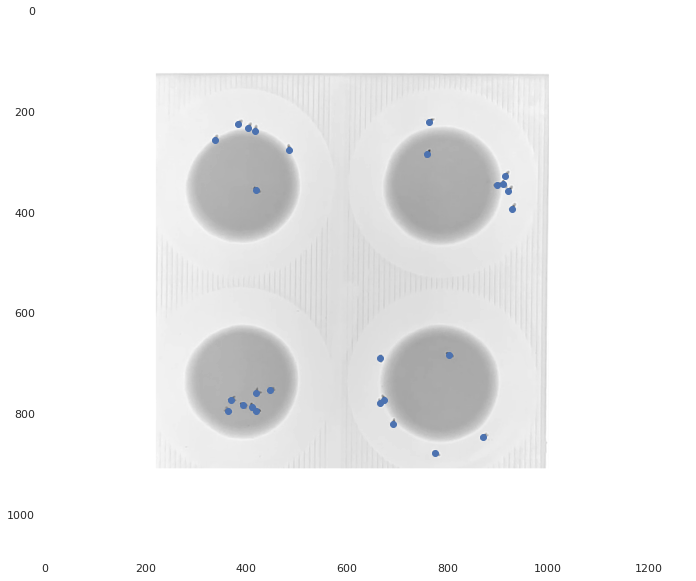

In [7]:
plt.figure(figsize=(15, 10))
plt.imshow(image, cmap='gray')

plt.scatter(*df.query(f"frame == {test_frame}")[["x", "y"]].to_numpy().T)
plt.grid(False)

In [8]:
# Getting pixels
threshold = 120
threshold_image = (image < threshold).astype("uint8")
fly_pixels = cv.findNonZero(threshold_image).squeeze()

In [9]:
# Getting initial value
init = df.query(f'frame == {test_frame-1}')[["x", "y"]].to_numpy().astype(np.float32)
n_flies = init.shape[0]

In [10]:
%%timeit
# sklearn baseline
reg = KMeans(n_clusters=n_flies, n_init=1, init=init, tol=1e-4, algorithm='full', )
sk_results = reg.fit(fly_pixels).cluster_centers_

1.89 ms ± 9.88 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%%timeit
# sklearn baseline
reg = KMeans(n_clusters=n_flies, n_init=1, init=init, tol=1e-4, algorithm='elkan', )
sk_results = reg.fit(fly_pixels).cluster_centers_

1.27 ms ± 19.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
reg = KMeans(n_clusters=n_flies, n_init=1, init=init, tol=1e-4, algorithm='full', )
sk_results = reg.fit(fly_pixels).cluster_centers_

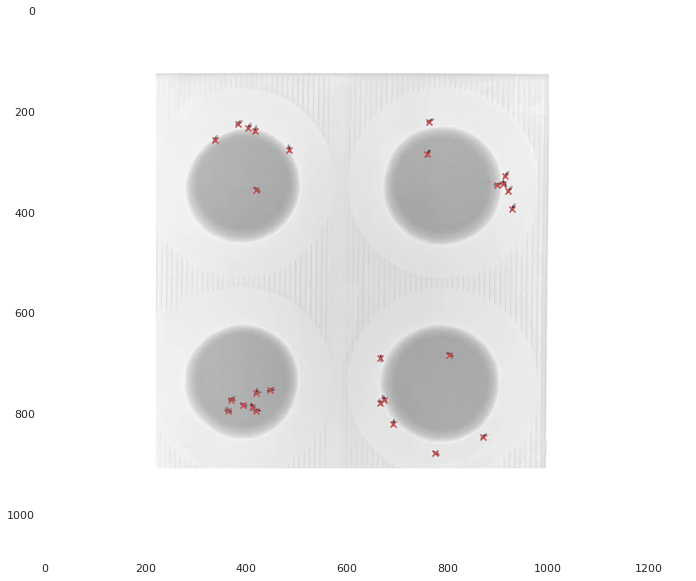

In [15]:
plt.figure(figsize=(15, 10))
plt.imshow(image, cmap='gray')
plt.scatter(*sk_results.T, marker='x', c='r')
plt.grid(False)

In [16]:
@jax.jit
def cdist(x, y):
    return jnp.linalg.norm(x[:, None, :] - y[None, :, :], axis=-1)

@jax.jit
def kmeans(X, init):
    def cond_fun(carry):
        new_centers, old_centers = carry
        return jnp.linalg.norm(new_centers - old_centers) > 1e-4
    
    def kmeans_step(X, mu):  
        # E step
        dist_matrix = cdist(X, mu)
        labels = jnp.argmin(dist_matrix, axis=1)

        # Mstep
        M = jnp.zeros((n_clusters, n_samples))
        M = jax.ops.index_update(M, (labels, jnp.arange(n_samples)), 1.0)
        new_mu= (M  / jnp.sum(M, axis=1, keepdims=True)) @ X
        return new_mu, labels

    def body_fun(carry):
        new, _ = carry 
        return step(new)[0], new
    
    n_clusters = init.shape[0]
    n_samples = X.shape[0]
    step = partial(kmeans_step, X)
    
    init_carry = (step(init)[0], init)
    mu, _ = lax.while_loop(cond_fun, body_fun, init_carry)
    _, labels = step(mu)
    return mu, labels

In [17]:
# Triggering jit
jax_results, jax_labels = kmeans(fly_pixels, init)

In [18]:
%%timeit
kmeans(fly_pixels, init)

222 µs ± 208 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


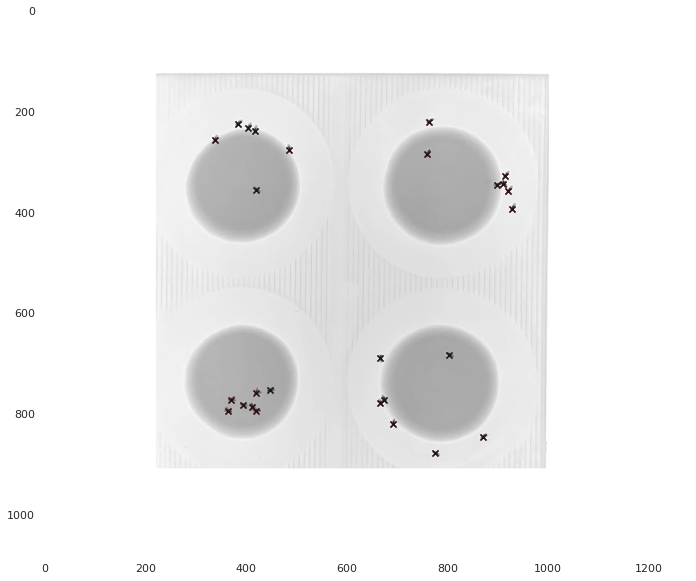

In [19]:
plt.figure(figsize=(15, 10))
plt.imshow(image, cmap='gray')
plt.scatter(*jax_results.T, marker='x', c='r')
plt.scatter(*sk_results.T, marker='x', c='k')
plt.grid(False)

In [21]:
diff = jnp.linalg.norm(sk_results - jax_results)
print(diff)

0.0004310439


So our unoptimized kmeans is already 2 times faster than sklearn... not bad. Let's test it for multiple frames:

In [22]:
n_tests = 1000
key = random.PRNGKey(42)
random_frames = random.choice(key, df.frame.unique(), shape=(n_tests, )).squeeze()

In [23]:
sk_results = []
jax_results = []
for idx in random_frames:
    image = load(original_path, frame=idx)
    
    threshold = 120
    threshold_image = (image < threshold).astype("uint8")
    fly_pixels = cv.findNonZero(threshold_image).squeeze()
    init = df.query(f'frame == {idx-1}')[["x", "y"]].to_numpy().astype(np.float32)
    n_flies = init.shape[0]
    
    #SKlearn
    reg = KMeans(n_clusters=n_flies, n_init=1, init=init, tol=1e-4, algorithm='full', )
    sk_results.append(reg.fit(fly_pixels).cluster_centers_)
    
    # Jax
    jax_results.append(kmeans(fly_pixels, init)[0])

In [24]:
diff = np.array([np.linalg.norm(jax-sk) for jax, sk in zip(sk_results, jax_results)])

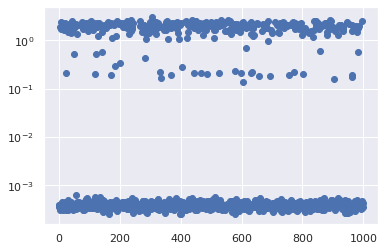

In [25]:
plt.semilogy(diff, 'o')

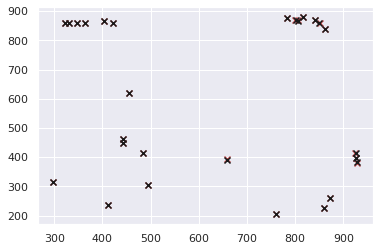

In [28]:
idx_highest_diff = np.argmax(diff)
plt.scatter(*jax_results[idx_highest_diff].T, marker='x', c='r')
plt.scatter(*sk_results[idx_highest_diff].T, marker='x', c='k')

#plt.xlim([300, 500])
#plt.ylim([200, 500])

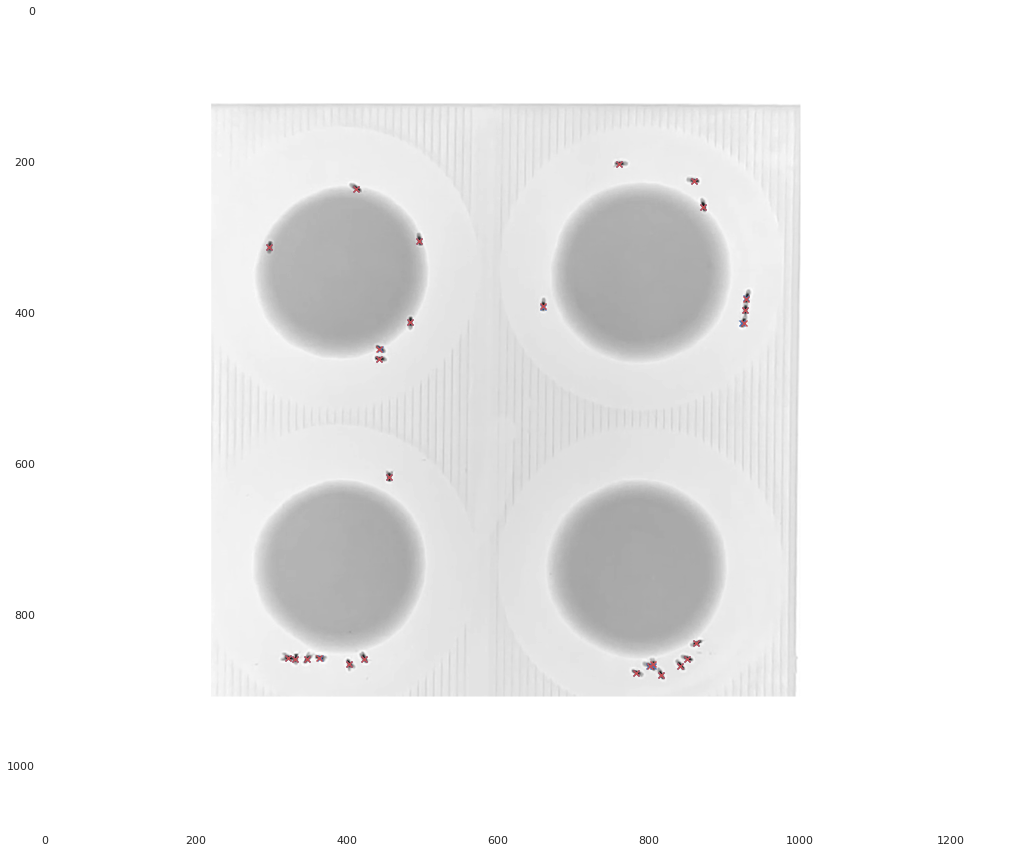

In [30]:
image = load(original_path, frame=random_frames[idx_highest_diff])
plt.figure(figsize=(25, 15))
plt.imshow(image, cmap='gray')
plt.scatter(*jax_results[idx_highest_diff].T, marker='x', c='b')
plt.scatter(*sk_results[idx_highest_diff].T, marker='x', c='r')
plt.grid(False)
#plt.xlim([300, 500])
plt.ylim([200, 500])

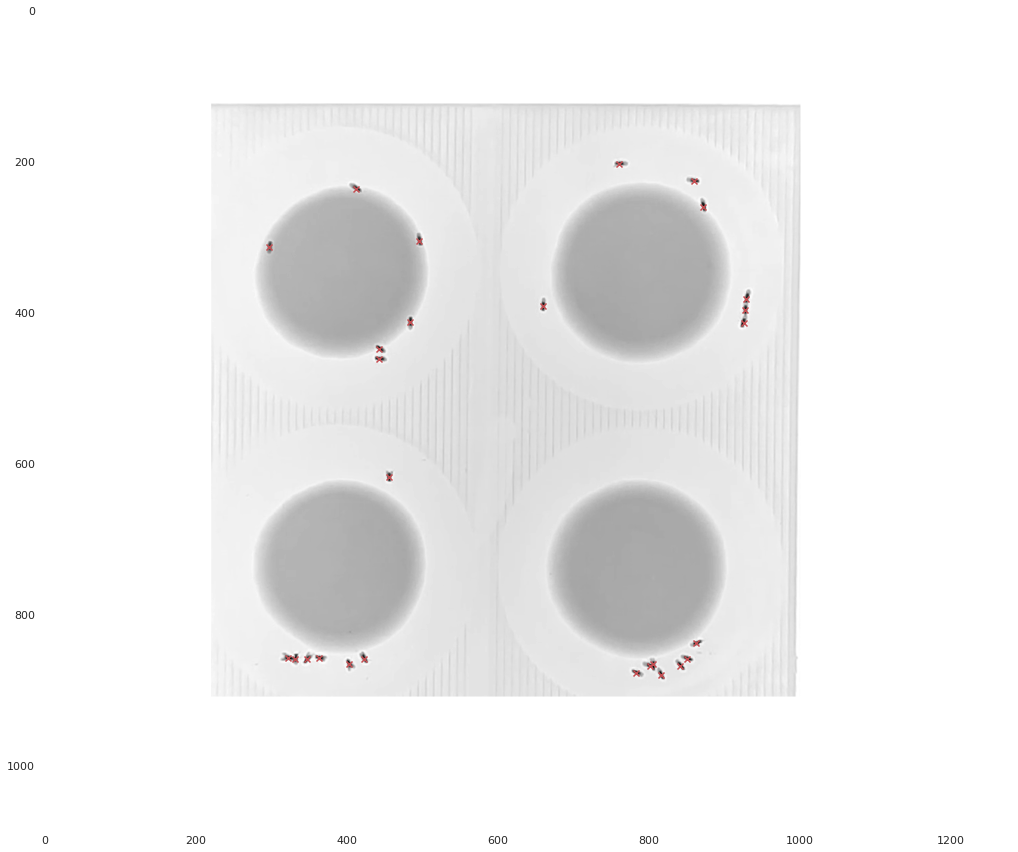

In [40]:
image = load(original_path, frame=random_frames[idx_highest_diff])
plt.figure(figsize=(25, 15))
plt.imshow(image, cmap='gray')
plt.scatter(*df.query(f"frame == {random_frames[idx_highest_diff]}")[["x", "y"]].to_numpy().T, marker='x', c='r')
plt.grid(False)

In [41]:
jax.__version__

'0.2.7'

In [42]:
from flytracker.kmeans import kmeans

In [ ]:
kmeans()